# <font color='blue'>Grouping Customers by Power Consumption</font>

Based on customer energy consumption data, we are going to group consumers by similarity in order to understand customer behavior and its relationship with energy consumption.

Dataset: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Loading data
dataset = pd.read_csv('data/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [3]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
dataset.shape

(2075259, 9)

In [5]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [6]:
# Checking for missing values
dataset.isnull().values.any()

True

In [7]:
# Remove records with NA values and remove the first two columns (not needed)
dataset = dataset.iloc[0:, 2:9].dropna()

In [8]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
# Checking for missing values
dataset.isnull().values.any()

False

In [10]:
# Get attribute values
dataset_atrib = dataset.values

In [11]:
dataset_atrib

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['0.938', '0.000', '239.820', ..., '0.000', '0.000', 0.0],
       ['0.934', '0.000', '239.700', ..., '0.000', '0.000', 0.0],
       ['0.932', '0.000', '239.550', ..., '0.000', '0.000', 0.0]],
      dtype=object)

In [12]:
# Collects a sample of 1% of the data so as not to compromise the computer's memory
sample1, sample2 = train_test_split(dataset_atrib, train_size = .01)

In [13]:
sample1.shape

(20492, 7)

In [14]:
# Apply dimensionality reduction
pca = PCA(n_components = 2).fit_transform(sample1)

In [15]:
# Determining a range of K
k_range = range(1,12)

In [16]:
# Applying the K-Means model to each value of K (this cell can take a long time to run)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [17]:
# Adjusting the cluster centroid for each model
centroids = [X.cluster_centers_ for X in k_means_var]

In [18]:
# Calculating the Euclidean distance of each data point to the centroid
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [19]:
# Sum of squares of distances within the cluster
squares_sum_intra_cluster = [sum(d**2) for d in dist]

In [20]:
# Total sum of squares
total_sum = sum(pdist(pca)**2)/pca.shape[0]

In [21]:
# Sum of squares between clusters
squares_sum_intra_cluster = total_sum - squares_sum_intra_cluster

Text(0.5, 1.0, 'Explained Variance x K Value')

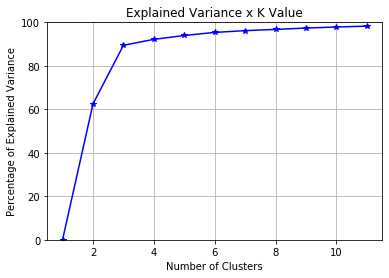

In [22]:
# Elbow Curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, squares_sum_intra_cluster/total_sum * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of Explained Variance')
plt.title('Explained Variance x K Value')

In [23]:
# Creating a model with K = 8
model_v1 = KMeans(n_clusters = 8)
model_v1.fit(pca)

KMeans()

In [24]:
# Get the minimum and maximum values and organize the shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = model_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

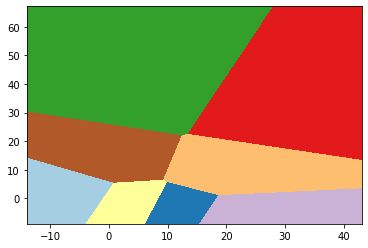

In [25]:
# Plot of cluster areas
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

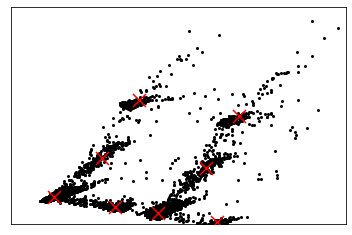

In [26]:
# Plot of centroids
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = model_v1.cluster_centers_
inert = model_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [27]:
# Silhouette Score
labels = model_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8109285557286058

In [28]:
# Creating a model with K = 10
model_v2 = KMeans(n_clusters = 10)
model_v2.fit(pca)

KMeans(n_clusters=10)

In [29]:
# Get the minimum and maximum values and organize the shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = model_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

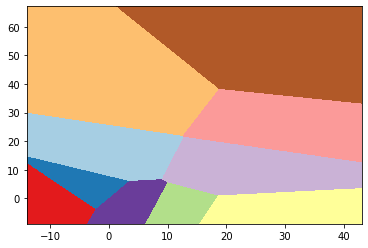

In [30]:
# Plot of cluster areas
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

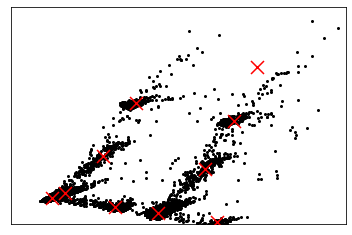

In [31]:
# Plot of centroids
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = model_v2.cluster_centers_
inert = model_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [32]:
# Silhouette Score
labels = model_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6622334485962933

Creating the Cluster Map with the clusters of Model V1 that presented the best Silhouette Score.

In [33]:
# List of column names
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [34]:
# Create the cluster map
cluster_map = pd.DataFrame(sample1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = model_v1.labels_

In [35]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.348,0.114,242.240,1.600,0.000,0.000,0,0
1,1.470,0.214,241.030,6.000,0.000,2.000,18,1
2,0.254,0.076,241.020,1.000,0.000,0.000,1,0
3,2.436,0.000,241.550,10.000,0.000,0.000,19,1
4,0.438,0.220,241.390,2.000,0.000,1.000,0,0
...,...,...,...,...,...,...,...,...
20487,2.342,0.062,242.840,9.600,0.000,0.000,0,0
20488,1.284,0.112,239.970,5.200,0.000,0.000,17,1
20489,1.238,0.082,237.170,5.200,0.000,0.000,17,1
20490,0.516,0.076,240.730,2.400,0.000,0.000,0,0


In [36]:
# Calculate average power consumption per cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.505289
1    1.799310
2    3.536876
3    4.568310
4    3.804424
5    2.418526
6    1.090223
7    2.551672
Name: Global_active_power, dtype: float64

### End